In [24]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib.lines import Line2D
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import plotly.express as px
import plotly.graph_objs as go
import imageio


# For feature selection
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# For model selection, modelling and testing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import LogisticRegression,RidgeClassifier,SGDClassifier,PassiveAggressiveClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC,LinearSVC,NuSVC
from sklearn.neighbors import KNeighborsClassifier,NearestCentroid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB,BernoulliNB

from sklearn.metrics import precision_score,accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,RepeatedStratifiedKFold
from sklearn.ensemble import VotingClassifier

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
from warnings import filterwarnings

In [25]:
data = pd.read_csv("heart.csv")
print("Dataset Shape: ", data.shape)
data

Dataset Shape:  (303, 14)


,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [26]:
data = data.rename(columns={
    'age': 'Age',
    'sex': 'Sex',
    'cp': 'ChestPainType',
    'trtbps': 'RestingBP',
    'chol': 'Cholesterol',
    'fbs': 'FastingBS',
    'restecg': 'RestECG',
    'thalachh': 'MaxHR',
    'exang': 'ExerciseAngina',
    'oldpeak': 'STDepression',
    'slope': 'STSlope',
    'ca': 'NumMajorVessels',
    'thal': 'ThalassemiaType',
    'output': 'HeartDisease'
})

# Print the new column names
print(data.columns)

Index(['Age', 'Sex', 'ChestPainType', 'RestingBP', 'Cholesterol', 'FastingBS',
       'RestECG', 'MaxHR', 'exng', 'STDepression', 'slp', 'caa', 'thall',
       'HeartDisease'],
      dtype='object')


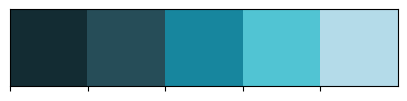

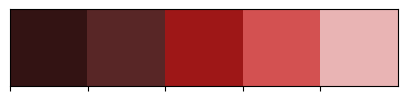

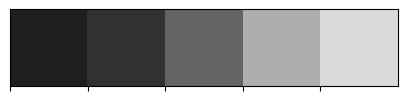

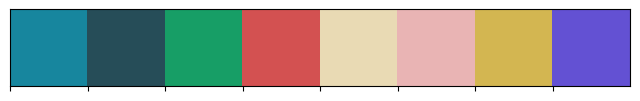

In [27]:
colors_blue = ["#132C33", "#264D58", '#17869E', '#51C4D3', '#B4DBE9']
colors_dark = ["#1F1F1F", "#313131", '#636363', '#AEAEAE', '#DADADA']
colors_red = ["#331313", "#582626", '#9E1717', '#D35151', '#E9B4B4']
colors_mix = ["#17869E", '#264D58', '#179E66', '#D35151', '#E9DAB4', '#E9B4B4', '#D3B651', '#6351D3']
sns.palplot(colors_blue)
sns.palplot(colors_red)
sns.palplot(colors_dark)
sns.palplot(colors_mix)

In [28]:
scatter = go.Scatter(
    x=data["Age"],
    y=data["MaxHR"],
    mode="markers",
    marker=dict(
        size=10,
        color=data["HeartDisease"],  # Color based on heart disease (1) or not (0)
        colorscale="Viridis",
        showscale=True,
    ),
    text=data.index,
    hovertemplate=(
        "Age: %{x}<br>"
        "Max Heart Rate: %{y}<br>"
        "Heart Disease: %{marker.color}<br>"
        "<extra></extra>"
    ),
)

layout = go.Layout(
    title="Age vs. Maximum Heart Rate",
    xaxis=dict(title="Age"),
    yaxis=dict(title="Maximum Heart Rate"),
    showlegend=False,
)

fig = go.Figure(data=[scatter], layout=layout)

# Show the interactive plot
fig.show()

In [29]:
gender_count = data.groupby(['Sex', 'HeartDisease']).size().reset_index(name='count')
gender_count['Sex'] = gender_count['Sex'].map({0: 'Female', 1: 'Male'})
gender_count['HeartDisease'] = gender_count['HeartDisease'].map({0: 'No', 1: 'Yes'})

fig = px.bar(gender_count, x='Sex', y='count', color='HeartDisease', 
             barmode='group', title='Count of Heart Disease Patients by Gender',
             labels={'Sex': 'Gender', 'count': 'Count', 'HeartDisease': 'Heart Disease'})

fig.show()

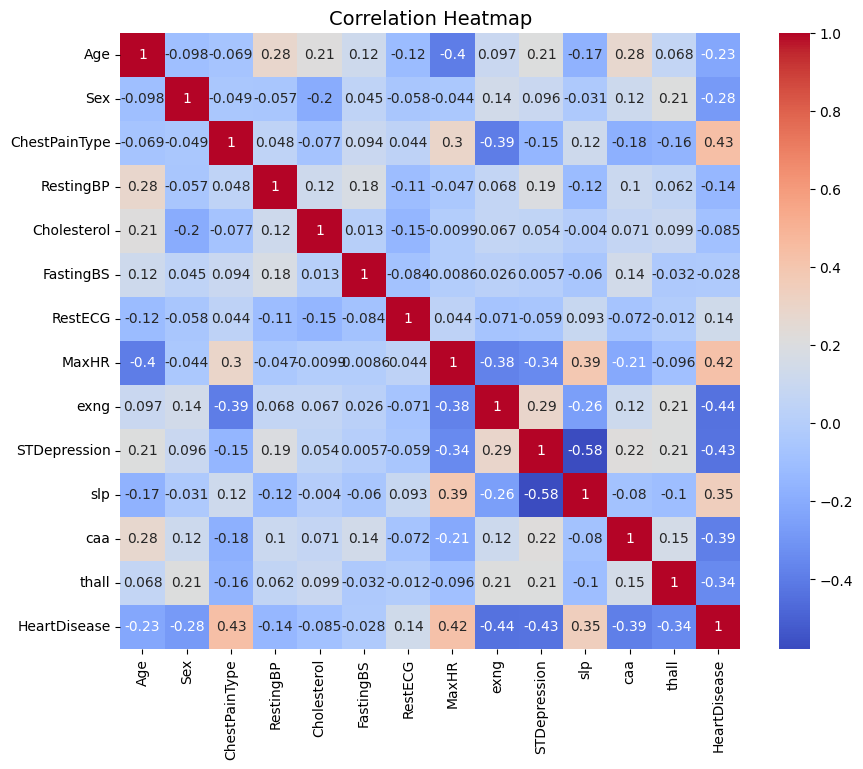

In [30]:
corr = data.corr()

fig, ax = plt.subplots(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap='coolwarm', ax=ax)

plt.title('Correlation Heatmap', fontsize=14)
plt.show()

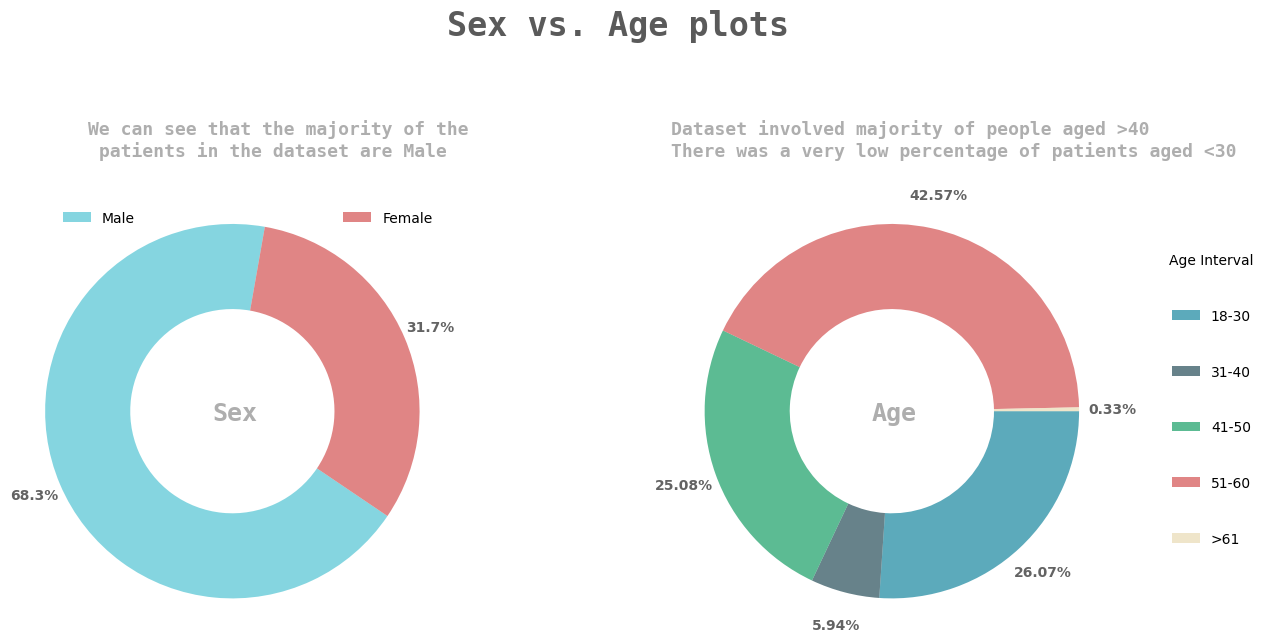

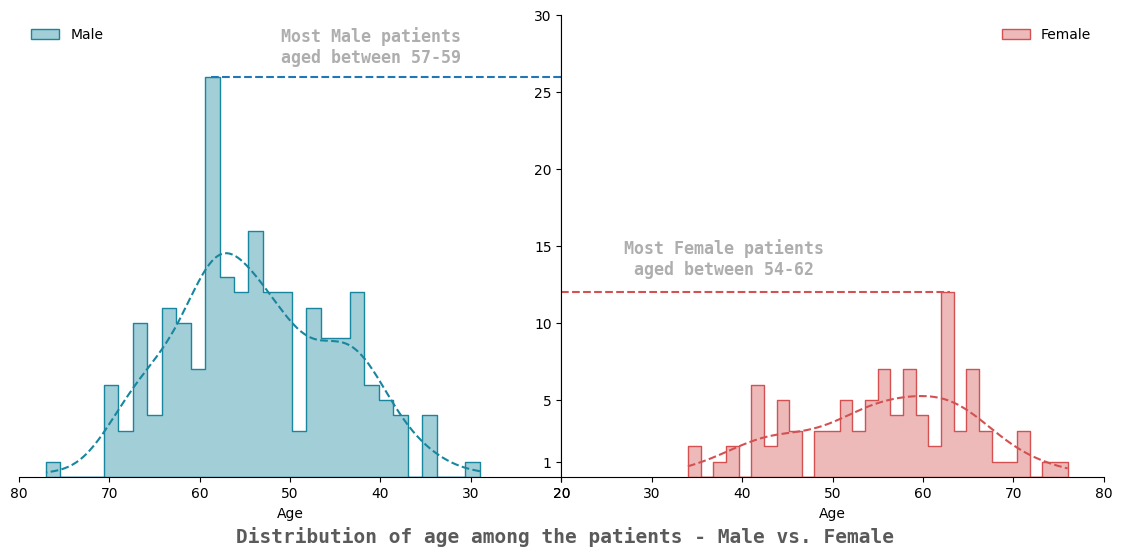

In [33]:
def grouping(age):
    if age>=18 and age<=30:
        return 0
    elif age>=31 and age<=40:
        return 1
    elif age>=41 and age<=50:
        return 2
    elif age>=51 and age<=60:
        return 3
    else:
        return 4
    
age_int = data['Age'].apply(grouping).value_counts(sort=False)

labels=['18-30','31-40','41-50','51-60','>61']


# Pie Charts

fig,ax = plt.subplots(1,2,figsize=(14,16))

fig.text(s='Sex vs. Age plots',size=24,fontweight='bold',fontname='monospace',
             color=colors_dark[1],y=0.73,x=0.43,alpha=0.8)

# Pie Chart - Left

ax[0].pie(data['Sex'].value_counts(),autopct='{:.1f}%'.format,
          colors=[colors_blue[3],colors_red[3]],wedgeprops={'width':0.5,'alpha':0.7},
          pctdistance=1.15,startangle=80,radius=1.1,textprops={'fontsize': 10, 'color': colors_dark[2],
                                                               'fontweight': 'bold'})

ax[0].legend(['Male','Female'],frameon=False,ncol=2,columnspacing=15,loc='upper right')

ax[0].text(s='We can see that the majority of the\n patients in the dataset are Male',
               fontdict={'color':colors_dark[3],'size':13,'fontweight':'bold','fontname':'monospace',
                         },x=-0.85,y=1.5)

ax[0].text(s='Sex',fontdict={'color':colors_dark[3],'size':18,'fontweight':'semibold','fontname':'monospace'}
           ,x=-0.12,y=-0.05)

#Pie Chart - Right

ax[1].pie(age_int,autopct='{:.2f}%'.format,colors=colors_mix,wedgeprops={'width':0.5,'alpha':0.7},
          pctdistance=1.18,radius=1.1,textprops={'fontsize': 10, 'color': colors_dark[2],'fontweight': 'bold'},
         counterclock=False)

ax[1].legend(labels,frameon=False,bbox_to_anchor=(1.38,0.9),labelspacing=3,title='Age Interval')

ax[1].text(s='Dataset involved majority of people aged >40\nThere was a very low percentage of patients aged <30',
               fontdict={'color':colors_dark[3],'size':13,'fontweight':'bold','fontname':'monospace',
                         },x=-1.3,y=1.5)

ax[1].text(s='Age',fontdict={'color':colors_dark[3],'size':18,'fontweight':'semibold','fontname':'monospace'}
           ,x=-0.12,y=-0.05)


fig.subplots_adjust(wspace=0.55)

# Histograms with KDE

fig,ax = plt.subplots(1,2,figsize=(14,6),sharey=False)

# Left Hist

sns.histplot(data[data['Sex']==1]['Age'],ax=ax[0],bins=30,alpha=0.4,color=colors_blue[2],
             element='step',kde=True,line_kws={'ls':'--'})
ax[0].set_xlim(20,80)
ax[0].set_ylim(0,30)
ax[0].invert_xaxis()
ax[0].spines['top'].set_color(None)
ax[0].spines['left'].set_color(None)
ax[0].yaxis.tick_right()
ax[0].set_ylabel(None)
ax[0].set_yticks([])
ax[0].set_xlabel('Age')
ax[0].legend(['Male'],loc='upper left',frameon=False)
ax[0].axhline(y=26,xmin=1,xmax=1-(39/60),ls='--')

ax[0].set_title('Most Male patients\naged between 57-59',y=0.88,x=0.65,
                fontdict={'color':colors_dark[3],'size':12,'fontweight':'bold','fontname':'monospace'})

# Right Hist

sns.histplot(data[data['Sex']==0]['Age'],ax=ax[1],bins=30,alpha=0.4,color=colors_red[3],
             element='step',kde=True,line_kws={'ls':'--'})
ax[1].set_xlim(20,80)
ax[1].set_ylim(0,30)
ax[1].spines['top'].set_color(None)
ax[1].spines['right'].set_color(None)
ax[1].set_ylabel(None)
ax[1].set_yticks([1,5,10,15,20,25,30])
ax[1].set_xlabel('Age')
ax[1].legend(['Female'],loc='upper right',frameon=False)
ax[1].axhline(y=12,xmin=0,xmax=43/60,ls='--',color=colors_red[3])

ax[1].set_title('Most Female patients\naged between 54-62',y=0.42,x=0.3,
                fontdict={'color':colors_dark[3],'size':12,'fontweight':'bold','fontname':'monospace'})
fig.subplots_adjust(wspace=0)

fig.text(s='Distribution of age among the patients - Male vs. Female',size=14,fontweight='bold',
             fontname='monospace',color=colors_dark[1],y=0,x=0.28,alpha=0.8)

plt.show()